In [385]:
import re
import numpy as np
from PIL import Image, ImageOps
import os
from itertools import cycle 
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

In [2]:
def read_image(filename):
    #read image and get size
    image = Image.open(filename)
    w, h = image.size
    
    #convert to grayscale
    gray_im = ImageOps.grayscale(image)
    
    #convert image to numpy array
    im_array = np.array(gray_im)
    
    return(im_array)

In [97]:
image = '/Users/davidschaupp/Downloads/Market-1501-v15.09.15/splitted_data/0001/0001_c1s1_001051_00.jpg'
array = read_image(image)
print(array.shape)

(128, 64)


In [34]:
sample_size = 10000
#samples, number of pairs, dim1, dim2
x_same_pair = np.zeros([sample_size, 2, 1, 128, 64])
y_same_pair = np.zeros([sample_size, 1])

x_different_pair = np.zeros([sample_size, 2, 1, 128, 64])
y_different_pair = np.zeros([sample_size, 1])

In [35]:
print(x_same_pair.shape)
print(y_same_pair.shape)
print(x_different_pair.shape)
print(y_different_pair.shape)

(10000, 2, 1, 128, 64)
(10000, 1)
(10000, 2, 1, 128, 64)
(10000, 1)


In [98]:
source_folder = '/Users/davidschaupp/Downloads/Market-1501-v15.09.15/splitted_data/'
folder_count = os.listdir(source_folder)
folder_count.sort()
print(len(folder_count))
#delete DS_Store files from folders
folder_count.pop(0)
folder_count.pop(0)
print(len(folder_count))

1503
1501


In [275]:
import glob
def get_data():
    
    #Create same pairs
    
    #create iterable object
    iter_obj_same = cycle(folder_count)
    #iterate over sample size
    for i in range(sample_size):
        current_folder = next(iter_obj_same)
        #get dir of image directory without hidden files
        image_dir = os.path.join(source_folder, current_folder)
        image_dir_copy = glob.glob(os.path.join(image_dir, '*'))
        #how many images in dir
        len_image_dir = len(image_dir_copy)
        
        #create two random numbers
        randoms = random.sample(range(len_image_dir), 2)
        im_1 = randoms[0]
        im_2 = randoms[1]
        
        #path of files
        path_im_1 = image_dir_copy[im_1]
        path_im_2 = image_dir_copy[im_2]
        
        #convert to arrays
        im_array_1 = read_image(path_im_1)
        im_array_2 = read_image(path_im_2)
  
        x_same_pair[i, 0, 0, :, :] = im_array_1
        x_same_pair[i, 1, 0, :, :] = im_array_2
        
        y_same_pair[i] = 1
        
    
    #create different pairs
    
    #list folders in source folder without hidden files
    folder_dir = glob.glob(os.path.join(source_folder, '*'))
    
    for i in range(sample_size):
    
        #select 2 folders
        randoms = random.sample(range(len(folder_dir)), 2)
        folder_1 = randoms[0]
        folder_2 = randoms[1]
        
        #get folder dir
        folder_1 = folder_dir[folder_1]
        folder_2 = folder_dir[folder_2]
        
        #len_of_folder
        folder_1_im = glob.glob(os.path.join(folder_1, '*'))
        len_folder_1 = len(folder_1_im)
        folder_2_im = glob.glob(os.path.join(folder_2, '*'))
        len_folder_2 = len(folder_2_im)
        
        
        #select random image in folder
        random_im_1 = random.sample(range(len_folder_1), 1)
        random_im_2 = random.sample(range(len_folder_2), 1)
        im_1 = random_im_1[0]
        im_2 = random_im_2[0] 
        
        #path of files
        path_im_1 = folder_1_im[im_1]
        path_im_2 = folder_2_im[im_2]
        
        #convert to arrays
        im_array_1 = read_image(path_im_1)
        im_array_2 = read_image(path_im_2)

        x_different_pair[i, 0, 0, :, :] = im_array_1
        x_different_pair[i, 1, 0, :, :] = im_array_2
        
        y_different_pair[i] = 0
    
    X = np.concatenate([x_same_pair, x_different_pair], axis=0)/255
    Y = np.concatenate([y_same_pair, y_different_pair], axis=0)
        
    return X, Y

        
        
    

In [276]:
X, Y = get_data()

In [329]:
#train / test split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.25)

In [330]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(15000, 2, 1, 128, 64)
(15000, 1)
(5000, 2, 1, 128, 64)
(5000, 1)


In [331]:
#switch axis for correct input
x_train = np.einsum("abcde->abdec", x_train)
x_test = np.einsum("abcde->abdec", x_test)
print(x_train.shape)
print(x_test.shape)

(15000, 2, 128, 64, 1)
(5000, 2, 128, 64, 1)


In [383]:
def plot_training(H):
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")

In [348]:
def build_siamese_model(input_shape):
    
    inputs = keras.layers.Input(input_shape)
    
    x = keras.layers.Conv2D(32, (2,2), padding="same", activation="relu")(inputs)
    x = keras.layers.MaxPool2D(2,2)(x)
    x = keras.layers.Dropout(0.2)(x)
    
    x = keras.layers.Conv2D(64, (2,2), padding="same", activation="relu")(x)
    x = keras.layers.MaxPool2D(2,2)(x)
    x = keras.layers.Dropout(0.2)(x)
    
    x = keras.layers.Conv2D(128, (2,2), padding="same", activation="relu")(x)
    x = keras.layers.MaxPool2D(2,2)(x)
    x = keras.layers.Dropout(0.2)(x)
    
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(128, activation="relu")(x)
    x = keras.layers.Dropout(0.2)(x)
    outputs = keras.layers.Dense(64, activation="relu")(x)
    
    model = keras.models.Model(inputs, outputs)
    
    return model

In [364]:
input_dim = (x_train.shape[2:])
img_a = keras.layers.Input(shape=input_dim)
img_b = keras.layers.Input(shape=input_dim)

#build the network
base_network = build_siamese_model(input_dim)

#return feature vectors
feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

In [365]:
base_network.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_51 (InputLayer)        [(None, 128, 64, 1)]      0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 128, 64, 32)       160       
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 64, 32, 32)        0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 64, 32, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 64, 32, 64)        8256      
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 32, 16, 64)        0         
_________________________________________________________________
dropout_50 (Dropout)         (None, 32, 16, 64)        0  

In [366]:
#compute distance between vects
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x-y), axis=1, keepdims=True))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

distance = keras.layers.Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])

In [372]:
epochs = 10
model = keras.models.Model(inputs=[img_a, img_b], outputs=distance)

In [375]:
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [376]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [379]:
img_1 = x_train[:, 0]
img_2 = x_train[:, 1]
history = model.fit([img_1, img_2], y_train, validation_split=.25, batch_size=128, epochs=epochs)

Train on 11250 samples, validate on 3750 samples
Epoch 1/10
11250/11250 [==============================] - 147s 13ms/sample - loss: 0.7398 - accuracy: 0.4954 - val_loss: 1.6777 - val_accuracy: 0.5048
Epoch 2/10
11250/11250 [==============================] - 151s 13ms/sample - loss: 0.7274 - accuracy: 0.4945 - val_loss: 1.6047 - val_accuracy: 0.5048
Epoch 3/10
11250/11250 [==============================] - 143s 13ms/sample - loss: 0.7246 - accuracy: 0.5048 - val_loss: 1.4784 - val_accuracy: 0.5048
Epoch 4/10
11250/11250 [==============================] - 143s 13ms/sample - loss: 0.7249 - accuracy: 0.4987 - val_loss: 1.3331 - val_accuracy: 0.5048
Epoch 5/10
11250/11250 [==============================] - 143s 13ms/sample - loss: 0.7218 - accuracy: 0.4991 - val_loss: 1.2705 - val_accuracy: 0.5048
Epoch 6/10
11250/11250 [==============================] - 143s 13ms/sample - loss: 0.7182 - accuracy: 0.5039 - val_loss: 1.3145 - val_accuracy: 0.5048
Epoch 7/10
11250/11250 [=====================

In [380]:
pred = model.predict([x_test[:, 0], x_test[:, 1]])

In [381]:
def compute_accuracy(predictions, labels):
    return labels[predictions.ravel() < 0.5].mean()

In [382]:
compute_accuracy(pred, y_test)

0.5134

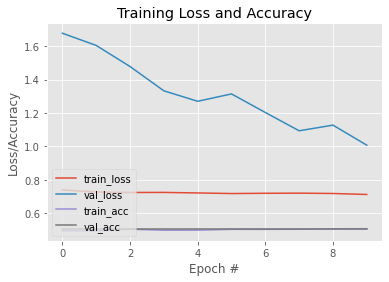

In [386]:
plot_training(history)